## Take home Exam 
### James Griffin-Gomez

### question: 
Can the zeta disease infection data be used to predict who will be infected on the Mars colony

#### Approach 
we will begin by visualizing the data, investigating the relationships from within the training data set, and investigating if ther is any null data and what we will do with that 

#### step 1 import libraries and data

In [4]:
## import libraries 
import pandas as pd
from pandas.plotting import scatter_matrix
import numpy as np 
import seaborn as sns 
import matplotlib.pyplot as plt 
import statsmodels.api as sm
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV, train_test_split
import pickle 
from sklearn.metrics import classification_report, f1_score, make_scorer

import warnings

# Ignore all warnings
warnings.filterwarnings('ignore')

In [5]:
#import data 

data = pd.read_excel('recruiting_zeta-disease_training-data_take-home-challenge.xlsx', 
                     sheet_name = '2021_zeta-disease_training-data')

In [6]:
data.head()

,age,weight,bmi,blood_pressure,insulin_test,liver_stress_test,cardio_stress_test,years_smoking,zeta_disease
0,54,189,27.1,80,0,1.5038,0,10,0
1,23,150,38.5,68,71,0.3868,55,2,0
2,47,186,29.9,90,0,0.2728,0,7,0
3,18,150,30.8,70,1033,0.6598,56,0,0
4,24,160,32.4,74,125,0.7608,59,2,0


In [7]:
data.isnull().sum()

age                   0
weight                0
bmi                   0
blood_pressure        0
insulin_test          0
liver_stress_test     0
cardio_stress_test    0
years_smoking         0
zeta_disease          0
dtype: int64

##### sweet no mising data

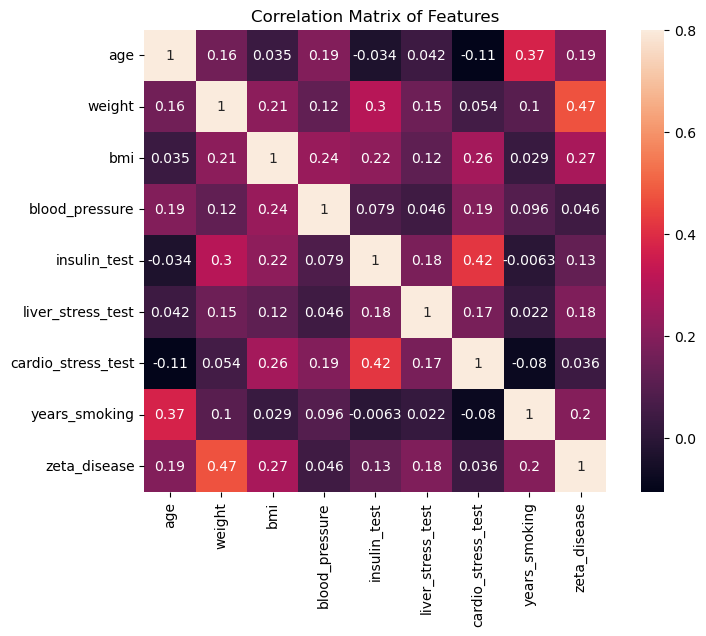

In [9]:
#heat map visualization
corr_mat = data.corr()
f, ax = plt.subplots(figsize = (9,6))
sns.heatmap(corr_mat,vmax=.8,square=True, annot = True)
plt.title("Correlation Matrix of Features")
plt.show()

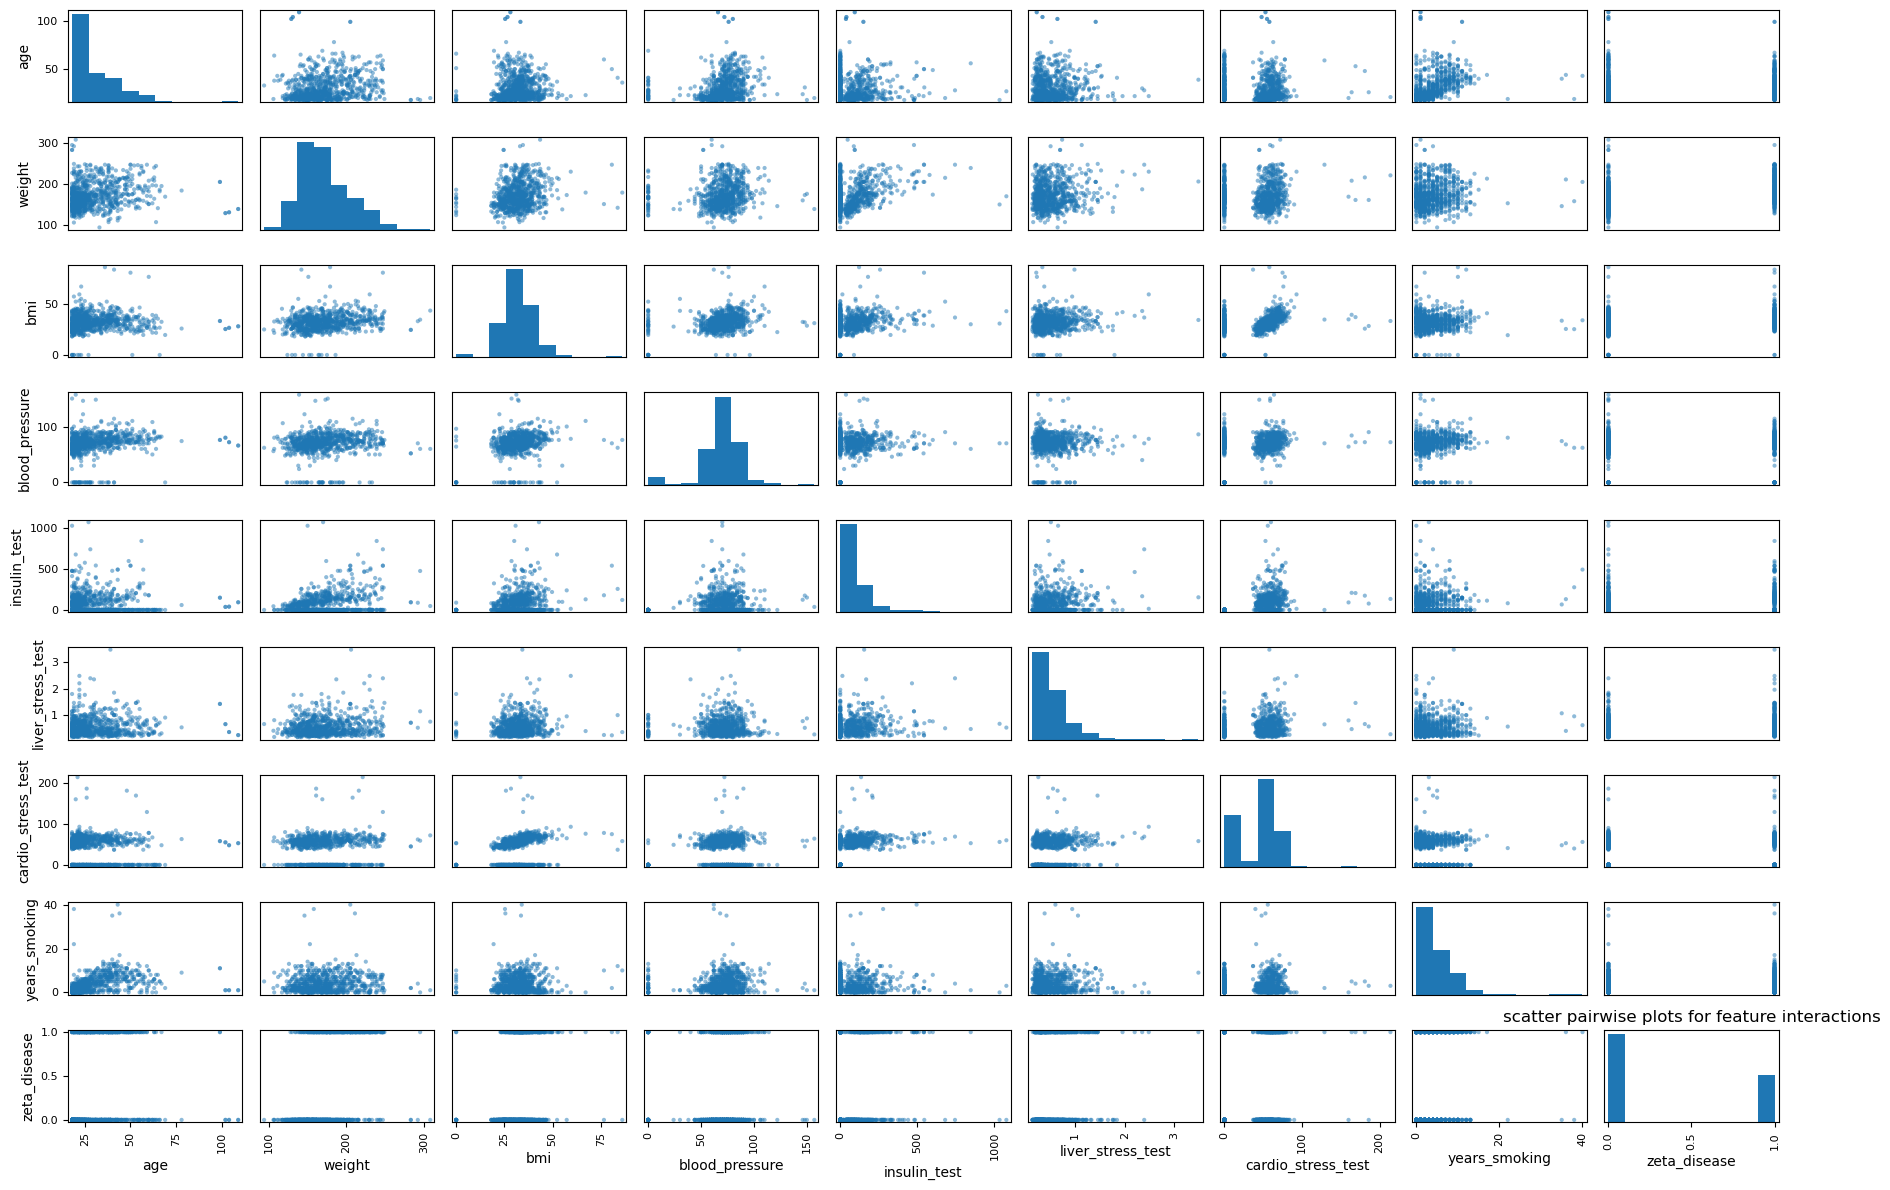

In [10]:
# scatter = data[["Score", "English", "Income",
#                   "Lunch", "Expenditure",'STratio']]

scatter_matrix(data, alpha = .5, figsize= [18, 12])
plt.title("scatter pairwise plots for feature interactions")
scatter_matrix
plt.tight_layout()
plt.show()

#### Ok so it doesnt look like we have anythign that is particularly co-linear BUT 
it does look like there are lots of values that are 0 for lots of values, so i want to investigat that, columns to investigate 

- cardio stress test
- insulin test

In [12]:
data['cardio_stress_test'].value_counts().head()

cardio_stress_test
0     227
62     31
60     29
53     25
58     24
Name: count, dtype: int64

In [13]:
data['insulin_test'].value_counts().head()

insulin_test
0      370
105     11
94      11
140      9
130      9
Name: count, dtype: int64

### ok so i need to know if the oversavtions of the 0s are the same people data['insulin_test'].value_counts()

In [15]:
test = pd.Series(data['insulin_test'] + data['cardio_stress_test'])
test.value_counts().head()


0     227
61     11
62     10
60      9
57      9
Name: count, dtype: int64

#### ok so it looks like that all of the cardio_stress 0's are also insulin test 0's 
I'm not 100% sure that 0s are a invalic, but i'm pretty sure, so i am going to drop those, because they are essentially null / missing 

In [17]:
excluded_data = data[data['cardio_stress_test'] != 0] 

<Axes: >

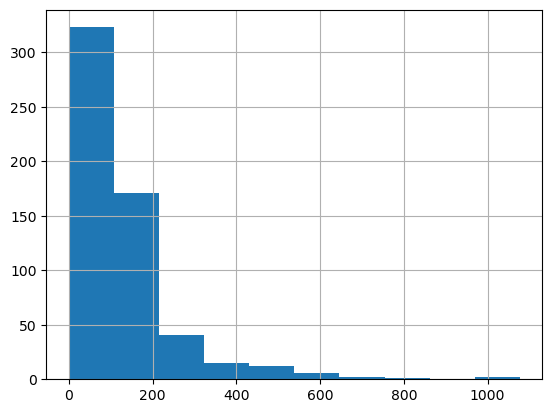

In [18]:
excluded_data['insulin_test'].hist()

In [19]:
excluded_data['insulin_test'].value_counts().head()

insulin_test
0      143
94      11
105     11
140      9
130      9
Name: count, dtype: int64

In [20]:
x = excluded_data[excluded_data['insulin_test']!=0]
x['insulin_test'].median()

125.0

Ok, so i don't want to exclude all of hte 0's data because i only have 800 training, and if I exclude 370 that is almost half, but i did exclude the observations that have both the insulin and cardio tests missing, just felt like there was too much missing to keep those values, so then for the remaining 143 observations from the excluded data with the mean of the non zero observations which is 125 

In [22]:
excluded_data['insulin_test'] = excluded_data['insulin_test'].apply(lambda x: x if x != 0 else 125.0)

#### Outcome distribution 

the last thing we need to check is the outcome distribution. If the outcome variable is heavily one or the other class, we will need to synthetically create, re-sample, or something along those line 

In [24]:
excluded_data['zeta_disease'].value_counts()

zeta_disease
0    382
1    191
Name: count, dtype: int64

ok this isnt too bad of a distribution, about 50% more 0's than 1's but if I used a boosted model like xgboost, this will take care of the unbalanced data for me. 

### Next step feature selection 

I will use a regularization regression approach to see what features i should use and then will use those featuers in prediction 

In [27]:
train_data = excluded_data.drop('zeta_disease', axis = 1)
train_y = excluded_data['zeta_disease']

In [28]:
model = sm.OLS(train_y, train_data)
lasso_result = model.fit_regularized(alpha = 0.1, L1_wt = 1)
# Output the coefficients
print(lasso_result.params)

age                   0.003492
weight                0.002708
bmi                   0.000000
blood_pressure       -0.004865
insulin_test          0.000336
liver_stress_test     0.000000
cardio_stress_test    0.000763
years_smoking         0.009217
dtype: float64


In [29]:
# Extract coefficients
params = lasso_result.params

# For standard errors, refit the model without regularization
# (Note: This is an approximation and not exactly accurate for the Lasso model)
ols_result = model.fit()

# Get standard errors, t-values, and p-values from the OLS model
std_errors = ols_result.bse
t_values = params / std_errors
p_values = ols_result.pvalues

# Print a formatted summary similar to Stata
summary_table = np.column_stack((params, std_errors, t_values, p_values))
headers = ["Coefficient", "Std. Err.", "t", "P>|t|"]
print(f"{'Variable':<10} {' '.join(f'{header:<12}' for header in headers)}")
print("-" * 55)
for i, row in enumerate(summary_table):
    print(f"{'X'+str(i):<10} " + " ".join(f"{val:<12.4f}" for val in row))

Variable   Coefficient  Std. Err.    t            P>|t|       
-------------------------------------------------------
X0         0.0035       0.0014       2.4753       0.0355      
X1         0.0027       0.0005       5.1149       0.0000      
X2         0.0000       0.0023       0.0000       0.2119      
X3         -0.0049      0.0011       -4.2458      0.0000      
X4         0.0003       0.0002       2.0073       0.1104      
X5         0.0000       0.0490       0.0000       0.0038      
X6         0.0008       0.0012       0.6559       0.9861      
X7         0.0092       0.0043       2.1234       0.0013      


ok so interesting, so a few things here: 
1. from above we know that Bmi, and liver_stress_test are both essentially excluded from the analysis with coefficients of 0,
2. both of the above mentioned veatures, as well as the feature blood_pressure, is given a p value of 0, meaning that there is basically 0 statistically significant relationship between blood pressure and the outcome variable

For these reasons i will exclude BMI, liver_stress_test, and blodd_pressure from the analysis. 

## Training step 

I think i will use the XGBoosted classifier, i like it because it gives me a couple of things that are nice in terms of prediction. it is very easy to explain how it uses gradient boosting and how it uses the random forest approach to split the data along the different axies. This is advantageous if i am going to explain the model i used to a non-technical share holder. It also gives the feature importance, which similar to the coefficients above. While not the exact, "for a one unit increase in feature X, we will expect the outcome to chage by y," but it does give us an idea of why the model is doing what its doing. For these reasons i have chosen the XGBoosted classifier 

In [32]:
train_df = excluded_data.drop(['bmi', 
                               'blood_pressure', 
                               'liver_stress_test',
                              'zeta_disease'], axis = 1)

In [33]:
train_cols = list(train_df.columns)

In [34]:
def train_step(df, y_data):
    '''takes in training data and outputs the feature analysis, 
    the pickled model, the pickled model will then be used in 
    prediction '''
  
    xclass = xgb.XGBClassifier()

    # using the train test split function
    X_train, X_val, y_train, y_val = train_test_split(
      df,y_data, random_state=2,test_size=0.25, shuffle=True)


    # Define the parameter grid
    parameters = {
        'learning_rate':  np.arange(0.01, 1.0, 0.01), 
        'max_depth': np.arange(5, 100, 3), 
        'subsample': np.arange(0.3, 0.7, 0.1),
        'colsample_bytree': np.arange(0.1, 1.0, 0.1),
        'n_estimators': np.arange(25, 1000, 25),
    }

    
    # Create a scorer that maximizes F1 score
    f1_scorer = make_scorer(f1_score, average='weighted')


    gs = RandomizedSearchCV(xclass, parameters, cv = 4, n_jobs=-1,  scoring=f1_scorer, n_iter=100,verbose=2)
  
    gs.fit(X_train, y_train)
    
    with open('pickled_out/xgb_model.pkl', 'wb') as file:
        pickle.dump(gs, file)
        
        
        
    boost_preds = gs.predict(X_val)
    return boost_preds, y_val, gs, gs.best_estimator_

In [35]:
val_preds, y_val, boosted_model, best_est = train_step(train_df, train_y)

Fitting 4 folds for each of 100 candidates, totalling 400 fits
[CV] END colsample_bytree=0.6, learning_rate=0.04, max_depth=41, n_estimators=175, subsample=0.6000000000000001; total time=   0.2s
[CV] END colsample_bytree=0.6, learning_rate=0.04, max_depth=41, n_estimators=175, subsample=0.6000000000000001; total time=   0.2s
[CV] END colsample_bytree=0.6, learning_rate=0.04, max_depth=41, n_estimators=175, subsample=0.6000000000000001; total time=   0.2s
[CV] END colsample_bytree=0.6, learning_rate=0.04, max_depth=41, n_estimators=175, subsample=0.6000000000000001; total time=   0.2s
[CV] END colsample_bytree=0.2, learning_rate=0.38, max_depth=92, n_estimators=450, subsample=0.6000000000000001; total time=   0.2s
[CV] END colsample_bytree=0.2, learning_rate=0.38, max_depth=92, n_estimators=450, subsample=0.6000000000000001; total time=   0.2s
[CV] END colsample_bytree=0.2, learning_rate=0.38, max_depth=92, n_estimators=450, subsample=0.6000000000000001; total time=   0.2s
[CV] END cols

In [36]:
# Generate the classification report
report = classification_report(y_val, val_preds)
print(report)

              precision    recall  f1-score   support

           0       0.74      0.93      0.82        88
           1       0.82      0.48      0.61        56

    accuracy                           0.76       144
   macro avg       0.78      0.71      0.72       144
weighted avg       0.77      0.76      0.74       144



In [37]:
best_est

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.02, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=89, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=250, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

### Ok so its not the best F1 in the whole world, but it is ok, at 77%, and for the purposes of this excersize, i think i have shown why i have done what i wanted to do 


### now read in prediction data, and predict 

In [39]:
pred_data = pd.read_excel('recruiting_zeta-disease_prediction-data_take-home-challenge (1).xlsx', 
                          sheet_name = '2021-01-21_zeta-disease_predict')

In [40]:
#subsetting to be the columns used in training 
pred_data2 = pred_data[train_cols]

In [41]:
predicted_outcomes = boosted_model.predict(pred_data2)
print(predicted_outcomes)

[0 0 0 0 1 0 0 0 0 0 1 1 0 1 1 1 1 1 0 1]


In [42]:
outcome_data = pred_data.copy()
outcome_data['zeta_disease'] = predicted_outcomes

In [43]:
outcome_data

,age,weight,bmi,blood_pressure,insulin_test,liver_stress_test,cardio_stress_test,years_smoking,zeta_disease
0,24,151,39.5,69,72,1.3968,56,4,0
1,27,179,35.5,89,156,1.6608,43,6,0
2,34,147,26.9,76,74,1.6958,53,2,0
3,35,206,32.4,73,127,1.4608,61,6,0
4,60,193,29.8,62,192,1.7798,65,9,1
5,45,120,36.5,108,50,1.2978,54,12,0
6,20,139,38.2,61,77,1.5818,68,3,0
7,23,137,31.2,70,73,1.4168,59,7,0
8,36,195,30.5,59,141,1.4498,59,6,0
9,19,193,25.8,84,66,1.7938,50,3,0


In [44]:
outcome_data.to_csv("Predictions_James_Griffin_Gomez.csv")